In [2]:
#Import necessary libraries (1).
import torch
import torch.nn as nn #Module wich contains all the necessary tools for building an ANN.
import torch.nn.functional as F #Module wich contains all the necessary functions used in a ANN.
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

In [4]:
#Import necessary libraries (2).
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
#%matplotlib inline

In [30]:
#Download train and test data.
transform = transforms.ToTensor() #Converts a numpy.ndarray to tensor.
train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transform)

In [31]:
#We convert train and test data to a set of batches.
#We shuffle the training data because we want a uniform distribution among classes in each batch.
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

# Toy CNN

---



Image Label: 3


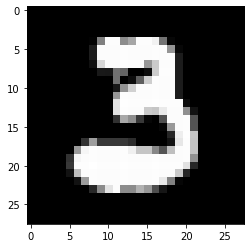

In [13]:
#Plot a random image from the train data.
np.random.seed(99)
random_image_n = np.random.randint(low=0, high=len(train_data))
plt.imshow(train_data[random_image_n][0].reshape(train_data[random_image_n][0].shape[1],train_data[random_image_n][0].shape[1]), cmap='gist_yarg_r')
plt.title(label=print(f'Image Label: {train_data[random_image_n][1]}'));

In [14]:
#Set up a toy-CNN and feed to it the above random image.
torch.manual_seed(99) #for reproducibility.
random_image = train_data[random_image_n][0].reshape(1,1,28,28) #Create a batch from the above random image
feature_maps1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1)(random_image)
act_feature_maps1 = F.relu(feature_maps1)
pooled_feature_maps1 = F.max_pool2d(act_feature_maps1,2,2)
feature_maps2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3, stride=1)(pooled_feature_maps1)
act_feature_maps2 = F.relu(feature_maps2)
pooled_feature_maps2 = F.max_pool2d(act_feature_maps2,2,2)

In [15]:
#Feature and activation map visualization.
def layerviz(covnetlayer,cols,rows=1,cmap='jet'):
    fig=plt.figure(figsize=(16, 16))
    if covnetlayer.shape[1] != cols*rows: 
      return print('The total number of plot s images exceeds the available image number in this layer...')
    else:
      for i in range(1, cols*rows +1):
        img = covnetlayer[0,i-1,:,:]
        fig.add_subplot(rows, cols, i)
        plt.title("Map: {}".format(i))
        plotable_image = img.reshape(covnetlayer.shape[2],covnetlayer.shape[3])
        plt.imshow(plotable_image.detach().numpy(), cmap=cmap)
      return plt.show()

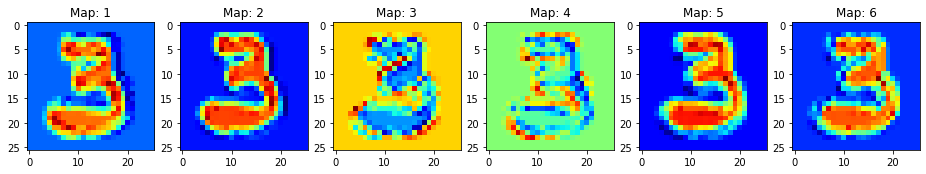

In [ ]:
layerviz(feature_maps1,6,1)

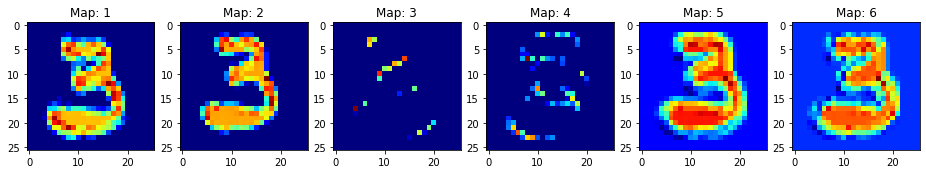

In [ ]:
layerviz(act_feature_maps1,6,1)

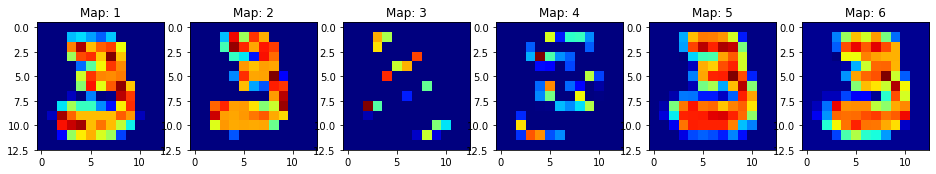

In [ ]:
layerviz(pooled_feature_maps1,6,1)

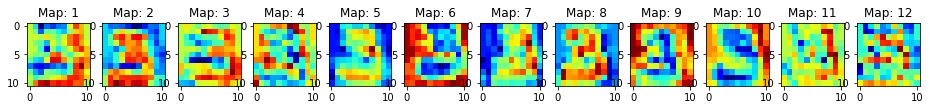

In [ ]:
layerviz(feature_maps2,12)

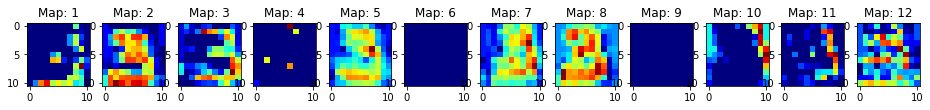

In [ ]:
layerviz(act_feature_maps2,12)

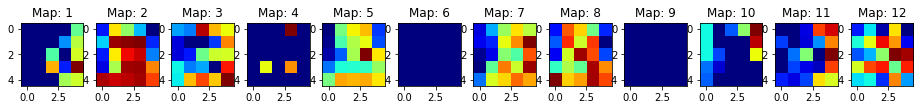

In [ ]:
layerviz(pooled_feature_maps2,12)

# Build the CNN

---



In [43]:
#Build the model.
class ConvNet(nn.Module): # Class ConvNet inherits all the methods and properties from the class "nn.Module".
    
    def __init__(self): #The 'self' variable represents the instance and the '__init__' function is the constructor.
        super().__init__() #The super() function is used to give access to methods and properties of a parent or sibling class. Returns an object that represents the parent class.
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(in_features=12*5*5, out_features=200)
        self.fc2 = nn.Linear(in_features=200, out_features=100)
        self.fc3 = nn.Linear(in_features=100, out_features=10)
   
    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        X = X.view(-1,12*5*5)# --------------> Image Flatenning (Reshaping from a 12 images of 5x5 to a column tensor of )
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        return F.log_softmax(self.fc3(X),dim=1)

In [44]:
#Set up the loss function and the optimizer.
torch.manual_seed(98)
model = ConvNet() #Create an istance of the ConvNet class.
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [45]:
#Calculate the total number of weights and biases.
c=1
weights = 0
biases = 0
for par in model.parameters():
  if c%2 !=0: 
    print('Layer number {} has {} weights '.format(c//2+1,par.numel()))
    weights+=par.numel()
  else: 
    print('Layer number {} has {} biases\n'.format(c//2,par.numel()))
    biases+=par.numel()
  c+=1
print(f'The CNN has a total of {weights+biases} parameters ({weights} weights and {biases} biases)')  

Layer number 1 has 54 weights 
Layer number 1 has 6 biases

Layer number 2 has 648 weights 
Layer number 2 has 12 biases

Layer number 3 has 60000 weights 
Layer number 3 has 200 biases

Layer number 4 has 20000 weights 
Layer number 4 has 100 biases

Layer number 5 has 1000 weights 
Layer number 5 has 10 biases

The CNN has a total of 82030 parameters (81702 weights and 328 biases)


# Train the model.

---



In [46]:
#Train the model.
import time
import math
starting_time = time.time()

#We must track the loss and the accuracy during the training phase.
training_loss_per_epoch = []
training_loss_per_batch = []
val_loss_per_epoch = []

training_correct_predictions = []
val_acc = []

epochs = 5
report_every_x_batches = 600
for epoch in range(epochs):

    #Training Data
    for batch, (X_train,y_train) in enumerate(train_loader):

        batch +=1 #So the number of the first batch is equal to one.
        y_pred = model(X_train)
        loss = loss_function(y_pred,y_train)

        #y_pred_vector = torch.max(y_pred, dim=1)[1]
        #corr_preds = (y_pred_vector==y_train).sum()
        #training_correct_predictions.append()
    
        #Backpropagation.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #Report while training.
        if batch%report_every_x_batches == 0: 
          print(f'We are in epoch number {epoch+1}, in batch {batch}, and the loss is {loss}')
          training_loss_per_batch.append(loss)
    training_loss_per_epoch.append(loss)


    #Validation Data.
    with torch.no_grad():
        for batch, (X_test,y_test) in enumerate(test_loader):
            y_pred_val = model(X_test)
    loss_val = loss_function(y_pred_val,y_test)
    val_loss_per_epoch.append(loss_val)
    print(f'-----In epoch {epoch+1}, loss in validation data is {loss_val}-----')

total_training_time = (time.time() - starting_time)/3600
hours = int(math.modf(total_training_time)[1])
minutes = round(math.modf(total_training_time)[0]*60,3)
print('The total training time is {} hours and {:.2} minutes'.format(hours,minutes))

We are in the epoch 1, in batch 600, and the loss is 0.6772150993347168
We are in the epoch 1, in batch 1200, and the loss is 0.25453513860702515
We are in the epoch 1, in batch 1800, and the loss is 0.01775932125747204
We are in the epoch 1, in batch 2400, and the loss is 0.005860825069248676
We are in the epoch 1, in batch 3000, and the loss is 0.1504519134759903
We are in the epoch 1, in batch 3600, and the loss is 0.1614578366279602
We are in the epoch 1, in batch 4200, and the loss is 0.008309844881296158
We are in the epoch 1, in batch 4800, and the loss is 0.021734271198511124
We are in the epoch 1, in batch 5400, and the loss is 0.0008577086846344173
We are in the epoch 1, in batch 6000, and the loss is 0.29982319474220276
-----In epoch 1 loss in validation data is 0.006888728588819504-----
We are in the epoch 2, in batch 600, and the loss is 0.005969586782157421
We are in the epoch 2, in batch 1200, and the loss is 0.006437167525291443
We are in the epoch 2, in batch 1800, and

# Evaluate the model.

---



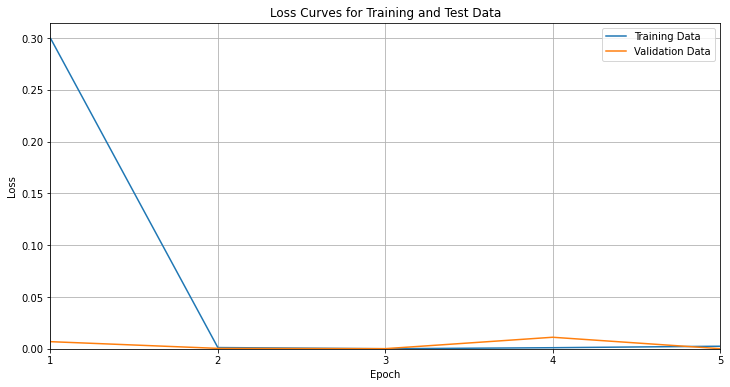

In [47]:
plt.figure(figsize=(12,6))
plt.title('Loss Curves for Training and Test Data')

plotable_list1 = [0]*(epochs+1)
plotable_list1[1:] = training_loss_per_epoch

plotable_list2 = [0]*(epochs+1)
plotable_list2[1:] = val_loss_per_epoch

plt.plot(plotable_list1,label='Training Data')
plt.plot(plotable_list2,label='Validation Data')

plt.xlabel("Epoch")
plt.xlim(1,epochs)
plt.xticks(np.linspace(1,epochs,epochs))

plt.ylabel("Loss")
plt.ylim(bottom=0)

plt.grid()
plt.legend();

In [55]:
#Feed all the test data in to the model.
test_data_all = DataLoader(test_data,batch_size=10000,shuffle=False)

with torch.no_grad():
    correct_guesses = 0
    for test_images, test_image_labels in test_data_all:
        pred_propabilities = model(test_image)
        pred_classes = torch.max(pred_propabilities, dim=1)[1]
        correct_guesses+=(pred_class==test_image_label).sum()

In [56]:
#Accuracy %
correct_guesses.item()*100/10000

98.83

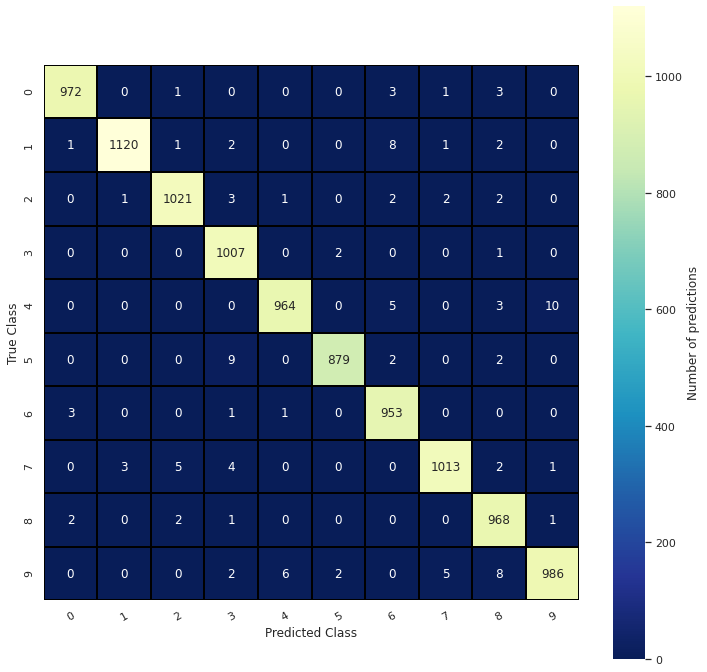

In [7]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

#Set plotting parameters.
plt.figure(figsize=(12,12))
sns.set(font_scale=1)

#Create the confusion matrix and save it as a .csv file.
#cm_df = pd.DataFrame(confusion_matrix(test_image_labels.view(-1,1), pred_classes.view(-1,1)))
#cm_df.to_csv('/content/drive/MyDrive/Projects/Python_Projects/CNN_MNIST_PyTorch/confusion_matrix.csv')

#Read the .csv file.
cm_df = pd.read_csv('/content/drive/MyDrive/Projects/Python_Projects/CNN_MNIST_PyTorch/confusion_matrix.csv', index_col=0) 

#Create a heatmap from the saved dataframe.
heatmap = sns.heatmap(cm_df, annot=True, square=True, fmt='d', cmap='YlGnBu_r', linecolor='black', linewidths=1, cbar_kws={'label': 'Number of predictions', 'orientation':'vertical'});
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=30) 

#Set axis labels.
plt.xlabel('Predicted Class')
plt.ylabel('True Class');